<a href="https://colab.research.google.com/github/gorzanskik-ai/PKO-BP/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dane

Dane pobrałem ze strony https://github.com/Ermlab/pl-sentiment-analysis. Zostały przygotowane pod zadanie analizy sentymentu. Zawierają recenzje oraz opinie z portalów takich jak m.in. Opineo, Twitter czy YouTube.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/job/PKO BP/polish_sentiment_dataset.csv'

Mounted at /content/drive


In [2]:
!pip install advertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 5.1 MB/s eta 0:00:00


In [3]:
# !python -m spacy download pl_core_news_sm

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import advertools as adv
import string
from collections import Counter
import numpy as np
import re
from nltk.util import ngrams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import spacy

In [5]:
df_raw = pd.read_csv(path)
df = df_raw.copy()
df.head()

,description,length,rate
0,Polecam nie pierwszy i nie ostatni raz!,39.0,1.0
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,121.0,1.0
2,Polecam zakupy w tym sklepie. Są dostępne częś...,87.0,1.0
3,0,0.0,0.0
4,Jestem w pełni zadowolona z przebiegu transakcji,48.0,1.0


Tabela składa się z trzech kolumn: 'description' - opinia lub recenzja, 'length' - ilość znaków z których się składa oraz 'rate' - informacja czy opinia jest pozytywna (1.0), negatywna (-1.0) lub neutralna (0.0). Zbiór danych jest niezbalansowany, liczność opinii pozytywnych znacznie przeważa nad opiniami negatywnymi oraz neutralnymi.

In [6]:
df['rate'].value_counts()

rate
 1.0    734250
-1.0    184020
 0.0     18547
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936883 entries, 0 to 936882
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  936254 non-null  object 
 1   length       762836 non-null  float64
 2   rate         936817 non-null  float64
dtypes: float64(2), object(1)
memory usage: 21.4+ MB


# 2. Preprocessing

## 2.1 Wartości null

Należy zacząć od usunięcia wierszy w których w kolumnie 'rate' lub 'description' znajduje się wartość null, takie wiersze będą nieprzydatne.

In [8]:
df.dropna(subset=['description', 'rate'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.isna().sum()

description         0
length         173384
rate                0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936188 entries, 0 to 936187
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  936188 non-null  object 
 1   length       762804 non-null  float64
 2   rate         936188 non-null  float64
dtypes: float64(2), object(1)
memory usage: 21.4+ MB


W kolumnie 'length' znajduje się wiele wartości null, które można w łatwy sposób uzupełnić. Znajduję listę indeksów wierszy z wartością null w kolumnie 'length', obliczam ilość znaków w danej recenzji i uzupełniam braki.

In [10]:
length_nan_indexes = df.index[df.isnull().any(axis=1)].tolist()
values_to_fill = [len(df.iloc[index]['description']) for index in length_nan_indexes]

In [11]:
for index, value in zip(length_nan_indexes, values_to_fill):
    df.at[index, 'length'] = value

In [12]:
df.isna().sum()

description    0
length         0
rate           0
dtype: int64

In [13]:
df['length'].describe()

count    936188.000000
mean         89.358998
std         134.170883
min           0.000000
25%          42.000000
50%          62.000000
75%          99.000000
max       26614.000000
Name: length, dtype: float64

## 2.2 Puste recenzje

W komórce powyżej zauważyłem, że istnieją puste recenzje (liczba znaków wynosi 0) oraz odchylenie standardowe w kolumnie 'length' jest dość wysokie.

In [14]:
empty_description = df[df['length'] == 0]
empty_description.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18547 entries, 3 to 762790
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  18547 non-null  object 
 1   length       18547 non-null  float64
 2   rate         18547 non-null  float64
dtypes: float64(2), object(1)
memory usage: 579.6+ KB


Recenzje które są 'puste', tak naprawdę składają się z '0' i są to wszystkie przypadki w których opinia jest neutralna (0.0).

In [15]:
empty_description['rate'].value_counts()

rate
0.0    18547
Name: count, dtype: int64

In [16]:
empty_description['description'].value_counts()

description
0    18547
Name: count, dtype: int64

Następnie uzupełniłem kolumnę length dla wspomnianych wierszy.

In [17]:
empty_description_indexes = empty_description.index
length_to_fill = [len(df.iloc[index]['description']) for index in empty_description_indexes]

In [18]:
for index, value in zip(empty_description_indexes, length_to_fill):
    df.at[index, 'length'] = value

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936188 entries, 0 to 936187
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  936188 non-null  object 
 1   length       936188 non-null  float64
 2   rate         936188 non-null  float64
dtypes: float64(2), object(1)
memory usage: 21.4+ MB


In [20]:
df['length'].describe()

count    936188.00000
mean         89.37881
std         134.15776
min           1.00000
25%          42.00000
50%          62.00000
75%          99.00000
max       26614.00000
Name: length, dtype: float64

In [21]:
df['rate'].value_counts()

rate
 1.0    734250
-1.0    183391
 0.0     18547
Name: count, dtype: int64

Brak pustych strignów

In [22]:
df[df['description'] == '']

,description,length,rate


'0' występuje tylko dla klasy neutralnej

In [23]:
df[df['description'] == '0']['rate'].value_counts()

rate
0.0    18547
Name: count, dtype: int64

## 2.3 Wartości odstające

Następnie z uwagi na wysokie odchylenie standardowe, usunąłem wartości odstające (osobno dla pozytywnych i negatywnych recenzji).

In [24]:
good_reviews = df[df['rate'] == 1.0]
bad_reviews = df[df['rate'] == -1.0]

In [25]:
q1_good = good_reviews['length'].quantile(0.25)
q3_good = good_reviews['length'].quantile(0.75)
iqr_good = q3_good - q1_good
low_good = q1_good - 1.5 * iqr_good
high_good = q3_good + 1.5 * iqr_good

q1_bad = bad_reviews['length'].quantile(0.25)
q3_bad = bad_reviews['length'].quantile(0.75)
iqr_bad = q3_bad - q1_bad
low_bad = q1_bad - 1.5 * iqr_bad
high_bad = q3_bad + 1.5 * iqr_bad

good_reviews = good_reviews[(good_reviews['length'] > low_good) & (good_reviews['length'] < high_good)]
bad_reviews = bad_reviews[(bad_reviews['length'] > low_bad) & (bad_reviews['length'] < high_bad)]

In [26]:
good_reviews['length'].describe()

count    681127.000000
mean         71.019616
std          35.047775
min          31.000000
25%          44.000000
50%          61.000000
75%          89.000000
max         182.000000
Name: length, dtype: float64

In [27]:
bad_reviews['length'].describe()

count    163468.000000
mean         63.658820
std          40.161429
min           1.000000
25%          33.000000
50%          51.000000
75%          84.000000
max         204.000000
Name: length, dtype: float64

# 3. Analiza statystyczna

In [28]:
def plot_histplot(good, bad, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
    sns.histplot(good, ax=ax1, color='Blue')
    ax1.set_title('Good reviews')
    sns.histplot(bad, ax=ax2, color='Red')
    ax1.set_xlabel('Length')
    ax1.set_ylabel('Count')
    ax2.set_title('Bad reviews')
    fig.suptitle(title)
    ax2.set_xlabel('Length')
    ax2.set_ylabel('Count')
    plt.show()

## 3.1 Wykres przedstawiający częstośc występowania recenzji o określonej liczbie znaków.

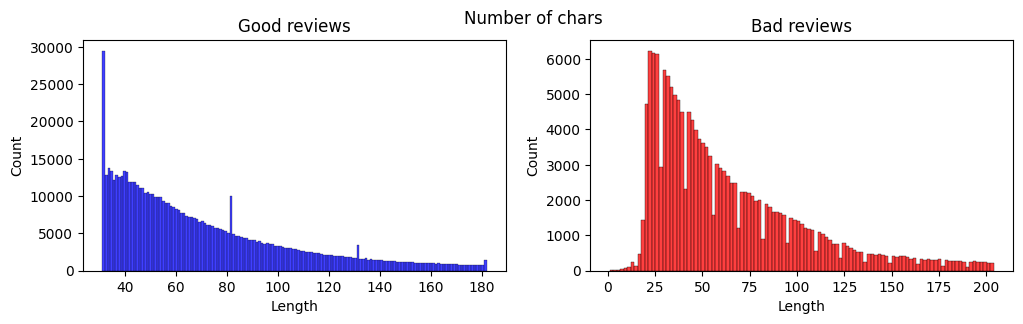

In [29]:
good_reviews_char = good_reviews['length']
bad_reviews_char = bad_reviews['length']

plot_histplot(good_reviews_char, bad_reviews_char, 'Number of chars')
#pozytywne opinie zaczynają się dopiero od 31 znaków

In [30]:
good_reviews_char.describe()

count    681127.000000
mean         71.019616
std          35.047775
min          31.000000
25%          44.000000
50%          61.000000
75%          89.000000
max         182.000000
Name: length, dtype: float64

In [31]:
bad_reviews_char.describe()

count    163468.000000
mean         63.658820
std          40.161429
min           1.000000
25%          33.000000
50%          51.000000
75%          84.000000
max         204.000000
Name: length, dtype: float64

## 3.2 Znaki interpunkcyjne

In [32]:
#punctuations
good_reviews_punctuations = good_reviews['description'].apply(lambda x: [c for c in x if c in string.punctuation])
bad_reviews_punctuations = bad_reviews['description'].apply(lambda x: [c for c in x if c in string.punctuation])

In [33]:
good_reviews_punctuations = good_reviews_punctuations[good_reviews_punctuations.str.len() != 0]
bad_reviews_punctuations = bad_reviews_punctuations[bad_reviews_punctuations.str.len() != 0]

In [34]:
good_reviews_punctuations_all = np.concatenate(good_reviews_punctuations.values).tolist()
bad_reviews_punctuations_all = np.concatenate(bad_reviews_punctuations.values).tolist()

In [35]:
good_punctuations_counter = Counter(good_reviews_punctuations_all)
bad_punctuations_counter = Counter(bad_reviews_punctuations_all)

In [36]:
good_punctuations_most_common = good_punctuations_counter.most_common(10)
bad_punctuations_most_common = bad_punctuations_counter.most_common(10)

Wykres przedstawiający najczęstsze znaki interpunkcyjne w recenzjach

In [37]:
def plot_histplot2(good, bad, title, fig_size = (15,5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    sns.barplot(x=[x[1] for x in good], y=[x[0] for x in good], ax=ax1, color='Blue')
    ax1.set_title('Good reviews')
    sns.barplot(x=[x[1] for x in bad], y=[x[0] for x in bad], ax=ax2, color='Red')
    ax2.set_title('Bad reviews')
    fig.suptitle(title)
    plt.show()

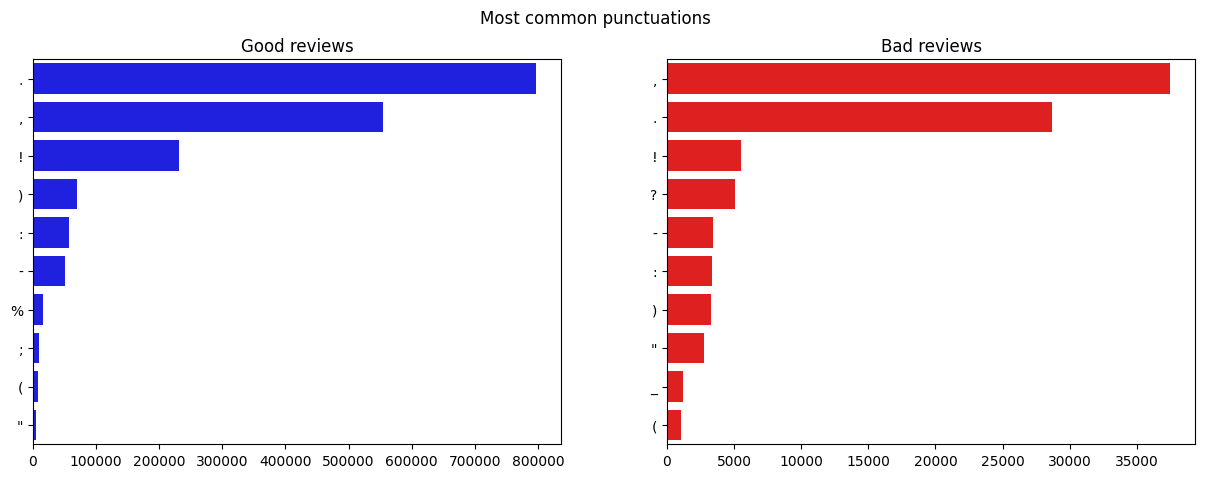

In [38]:
plot_histplot2(good_punctuations_most_common, bad_punctuations_most_common, 'Most common punctuations')

## 3.3 Oczyszczenie danych

Oczyszczenie polega na usunięciu znaków specjalnych oraz interpunkcyjnych, usunięciu zbędnych spacji oraz pomniejszeniu wszystkich liter.

In [39]:
#nlp = spacy.load("pl_core_news_sm")

good_reviews['description'] = good_reviews['description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
good_reviews['description'] = good_reviews['description'].str.split().apply(lambda x: [i.lower().strip() for i in x])
good_reviews['description'] = good_reviews['description'].apply(lambda x: ' '.join(x))
# good_reviews['description'] = good_reviews['description'].apply(lambda x: [token.lemma_ for token in nlp(x)])
# good_reviews['description'] = good_reviews['description'].apply(lambda x: ' '.join(x))

bad_reviews['description'] = bad_reviews['description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
bad_reviews['description'] = bad_reviews['description'].str.split().apply(lambda x: [i.lower().strip() for i in x])
bad_reviews['description'] = bad_reviews['description'].apply(lambda x: ' '.join(x))
# bad_reviews['description'] = bad_reviews['description'].apply(lambda x: [token.lemma_ for token in nlp(x)])
# bad_reviews['description'] = bad_reviews['description'].apply(lambda x: ' '.join(x))

## 3.4 Wykres przedstawiający częstość występowania słów

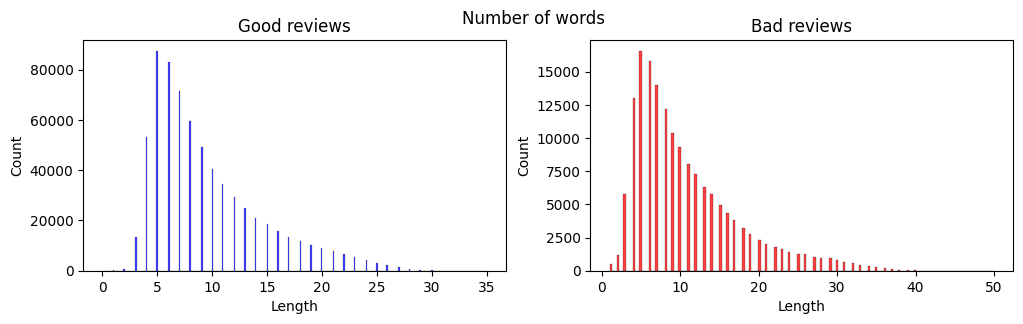

In [40]:
good_reviews_word = good_reviews['description'].str.split().apply(lambda x: len(x))
bad_reviews_word = bad_reviews['description'].str.split().apply(lambda x: len(x))

plot_histplot(good_reviews_word, bad_reviews_word, 'Number of words')

In [41]:
good_reviews_word.describe()

count    681127.000000
mean          9.516786
std           5.117186
min           0.000000
25%           6.000000
50%           8.000000
75%          12.000000
max          35.000000
Name: description, dtype: float64

In [42]:
bad_reviews_word.describe()

count    163468.000000
mean         10.717951
std           6.723011
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max          50.000000
Name: description, dtype: float64

## 3.5 Wykres przedstawiający częstośc występowania recenzji o określonej liczbie stopwords.

Stopwords to zestaw słów najczęściej używanych w danym języku. W języku polskim jest to np. a, aby, jest, kiedy, kto, ku, lub, ma, nim, niż, no, o, itd. Słowa to mają niską użyteczność dla zrozumienia wydźwięku tekstu.

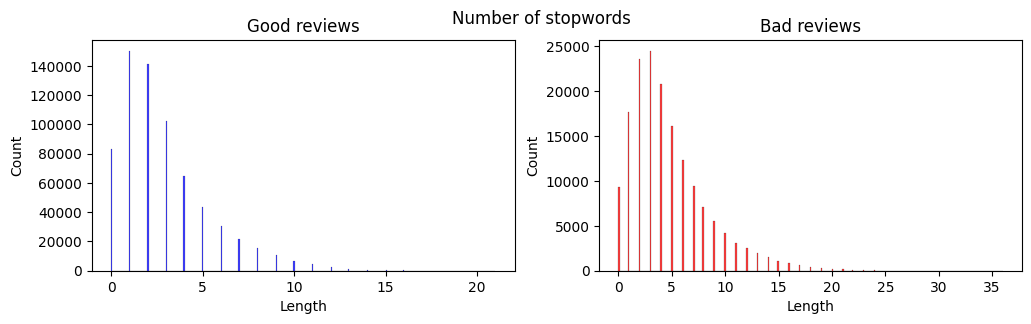

In [43]:
#stopwords
good_reviews_stopwords = good_reviews['description'].str.split().apply(lambda x: len([w for w in x if w in adv.stopwords['polish']]))
bad_reviews_stopwords = bad_reviews['description'].str.split().apply(lambda x: len([w for w in x if w in adv.stopwords['polish']]))

plot_histplot(good_reviews_stopwords, bad_reviews_stopwords, 'Number of stopwords')

In [44]:
good_reviews_stopwords.describe()

count    681127.000000
mean          2.890126
std           2.526632
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          21.000000
Name: description, dtype: float64

In [45]:
bad_reviews_stopwords.describe()

count    163468.000000
mean          4.708359
std           3.694393
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          36.000000
Name: description, dtype: float64

## 3.6 Zbudowanie korpusu dla dobrych i złych recenzji

In [46]:
def corpus(reviews):
    corpus = []

    for review in reviews['description'].str.split():
        for w in review:
            corpus.append(str.lower(w))
    return corpus

#all words
good_reviews_corpus = corpus(good_reviews)
bad_reviews_corpus = corpus(bad_reviews)

good_counter=Counter(good_reviews_corpus)
bad_counter=Counter(bad_reviews_corpus)

## 3.7 Wykres przedstawiający 40 najczęściej występujących słów w pozytywnych i negatywnych recenzjach.

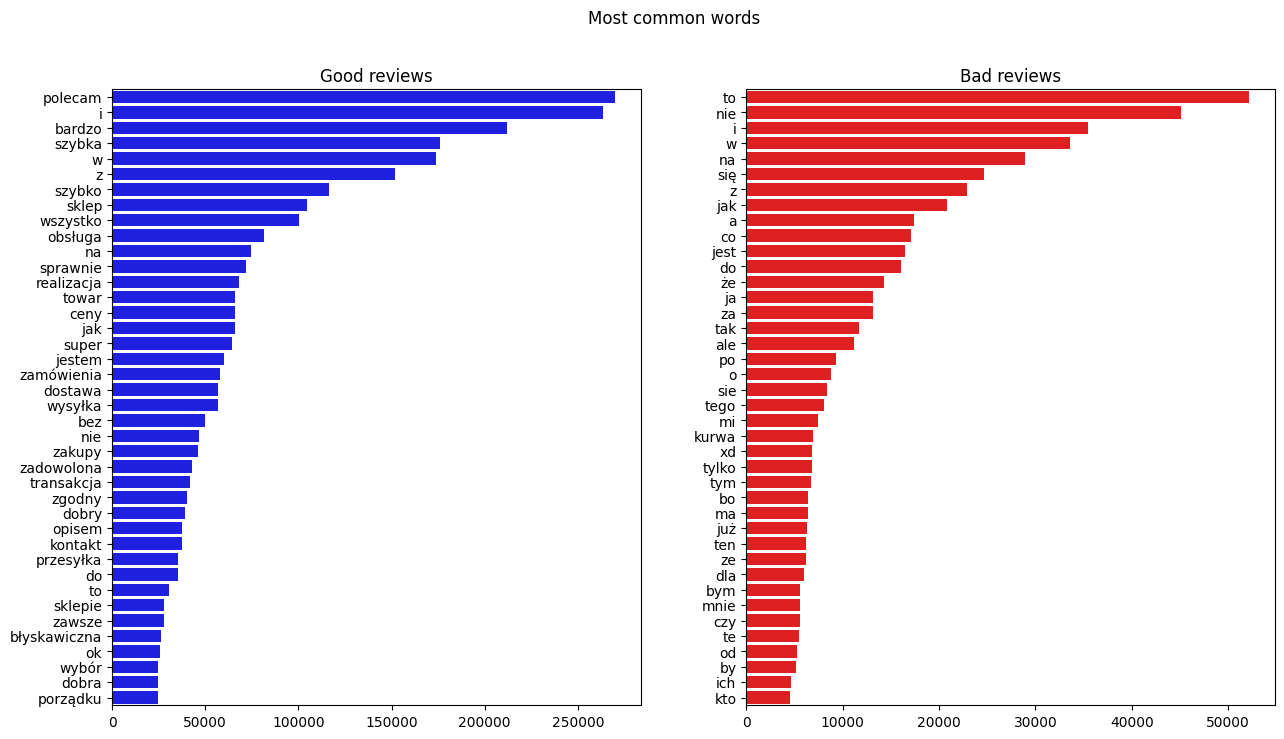

In [47]:
good_most=good_counter.most_common(40)
bad_most=bad_counter.most_common(40)

plot_histplot2(good_most, bad_most, 'Most common words', fig_size=(15, 8))

## 3.8 Wykres przedstawiający 40 najczęściej występujących słów w pozytywnych i negatywnych recenzjach bez stopwords

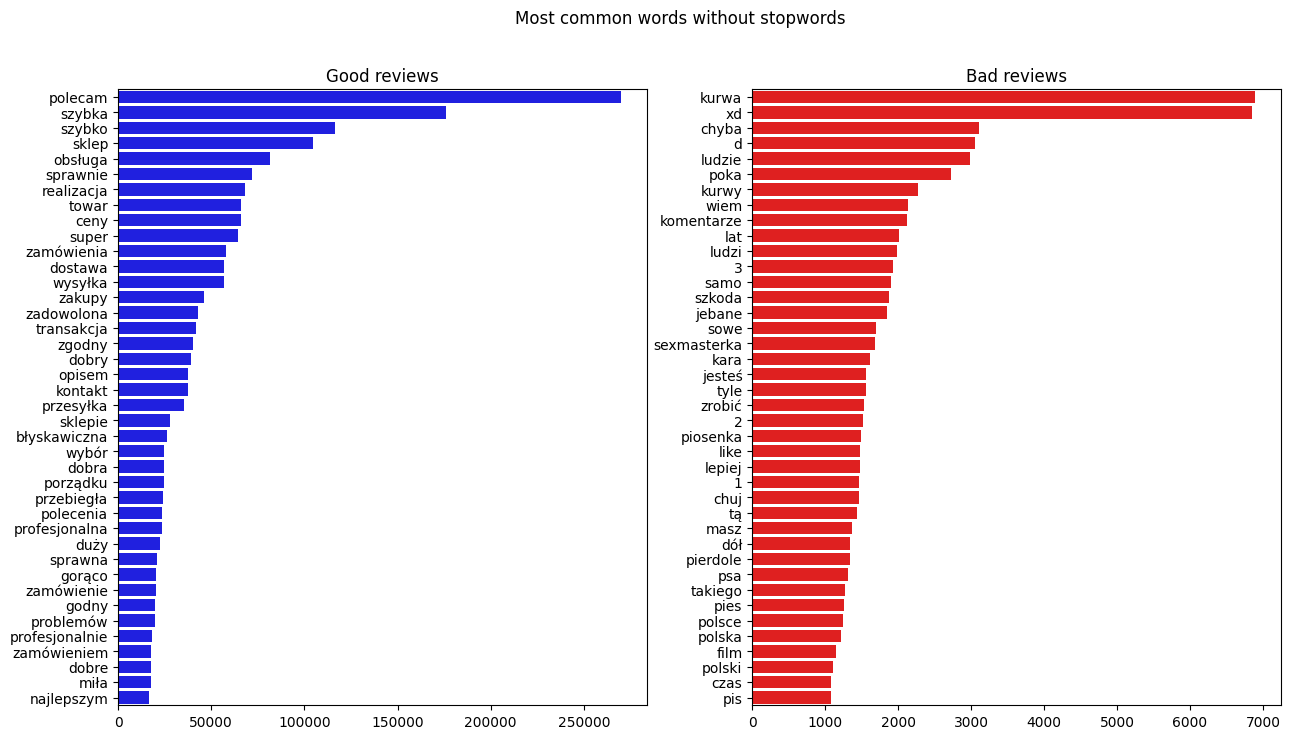

In [48]:
good_most_no_stopwords = [i for i in good_counter.most_common() if i[0] not in adv.stopwords['polish']][:40]
bad_most_no_stopwords = [i for i in bad_counter.most_common() if i[0] not in adv.stopwords['polish']][:40]

plot_histplot2(good_most_no_stopwords, bad_most_no_stopwords, 'Most common words without stopwords', fig_size=(15, 8))

## 3.9 Ngramy

In [49]:
def n_gram(n, data):
    corpus = []
    for review in data:
        words = review.split()
        if len(words) >= n:
            corpus.extend(list(ngrams(words, n)))
    return corpus

In [50]:
def plot(good, bad, n, width):
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Bar(x=[x[1] for x in good][::-1], y=[str(x[0]) for x in good][::-1], orientation='h', name='good reviews'), row=1, col=1)
    fig.add_trace(go.Bar(x=[x[1] for x in bad][::-1], y=[str(x[0]) for x in bad][::-1], orientation='h', name='bad reviews'), row=1, col=2)
    fig.update_layout(height=800, width=width, title_text=f'Ranking of most common {n} grams', title_x=0.5)
    fig.show()

### 3.9.1 Wykres przedstawiający 40 najczęściej występujących bigramów

In [51]:
good_bigram = n_gram(2, good_reviews['description'])
bad_bigram = n_gram(2, bad_reviews['description'])

good_bigram_counter=Counter(good_bigram)
bad_bigram_counter=Counter(bad_bigram)
good_bigram_most = good_bigram_counter.most_common(40)
bad_bigram_most = bad_bigram_counter.most_common(40)

plot(good_bigram_most, bad_bigram_most, 2, 1200)

### 3.9.2 Wykres przedstawiający 40 najczęściej występujących trigramów

In [52]:
good_trigram = n_gram(3, good_reviews['description'])
bad_trigram = n_gram(3, bad_reviews['description'])

good_trigram_counter=Counter(good_trigram)
bad_trigram_counter=Counter(bad_trigram)
good_trigram_most = good_trigram_counter.most_common(40)
bad_trigram_most = bad_trigram_counter.most_common(40)

plot(good_trigram_most, bad_trigram_most, 3, 1400)

### 3.9.3 Wykres przedstawiający 40 najczęściej występujących quadgramów

In [53]:
good_quadgram = n_gram(4, good_reviews['description'])
bad_quadgram = n_gram(4, bad_reviews['description'])

good_quadgram_counter=Counter(good_quadgram)
bad_quadgram_counter=Counter(bad_quadgram)
good_quadgram_most = good_quadgram_counter.most_common(40)
bad_quadgram_most = bad_quadgram_counter.most_common(40)

plot(good_quadgram_most, bad_quadgram_most, 4, 1800)

### 3.9.4 Wykres przedstawiający 40 najczęściej występujących pentagramów

In [54]:
good_pentagram = n_gram(5, good_reviews['description'])
bad_pentagram = n_gram(5, bad_reviews['description'])

good_pentagram_counter=Counter(good_pentagram)
bad_pentagram_counter=Counter(bad_pentagram)
good_pentagram_most = good_pentagram_counter.most_common(40)
bad_pentagram_most = bad_pentagram_counter.most_common(40)

plot(good_pentagram_most, bad_pentagram_most, 5, 1800)

# Zapisanie oczyszczonych danych

In [55]:
clean_data = pd.concat([good_reviews[['description', 'rate']], bad_reviews[['description', 'rate']], df[df['rate'] == 0.0][['description', 'rate']]], axis=0, ignore_index=True)
clean_data.to_csv('/content/drive/MyDrive/job/PKO BP/polish_sentiment_dataset_clean.csv', index=False)